# Data Preprocessing

In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time

import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix



In [2]:

from keras import utils as np_utils

# The path of our data on drive

In [3]:

data_dir =  r'D:\project covid\dataset'


In [4]:
data = load_files(data_dir)

In [5]:
folders=os.listdir("D:\project covid\dataset")
print(folders)

['COVID', 'Normal']


# Convert the data and labels to Numpy arrays

In [6]:

X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  D:\project covid\dataset\Normal\Normal-9506.png
Target labels -  1
Number of training files :  13808
Number of training targets :  13808


#### We have one folder for each flower classe or type. We are going to load it into two numpy arrays as follows : 

- X - filenames (Training data)
- y - flower names(Target labels)

### Convert images to arrays

In [7]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))


In [8]:

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(13808, 224, 224, 3)
First training item :  [[[96. 96. 96.]
  [41. 41. 41.]
  [26. 26. 26.]
  ...
  [50. 50. 50.]
  [65. 65. 65.]
  [82. 82. 82.]]

 [[37. 37. 37.]
  [ 7.  7.  7.]
  [ 2.  2.  2.]
  ...
  [ 4.  4.  4.]
  [ 8.  8.  8.]
  [15. 15. 15.]]

 [[29. 29. 29.]
  [ 5.  5.  5.]
  [ 1.  1.  1.]
  ...
  [ 0.  0.  0.]
  [ 2.  2.  2.]
  [ 4.  4.  4.]]

 ...

 [[ 5.  5.  5.]
  [ 2.  2.  2.]
  [ 1.  1.  1.]
  ...
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 4.  4.  4.]]

 [[ 7.  7.  7.]
  [ 2.  2.  2.]
  [ 2.  2.  2.]
  ...
  [ 1.  1.  1.]
  [ 2.  2.  2.]
  [ 5.  5.  5.]]

 [[12. 12. 12.]
  [ 6.  6.  6.]
  [ 5.  5.  5.]
  ...
  [ 1.  1.  1.]
  [ 3.  3.  3.]
  [ 7.  7.  7.]]]


- **13808** is the **number** of training items or files,
- **(224,224)** is the **target size** or image size provided while loading image
- **3** refers to the **depth** for colored images ( RGB channels ).

### look at first 5 training data

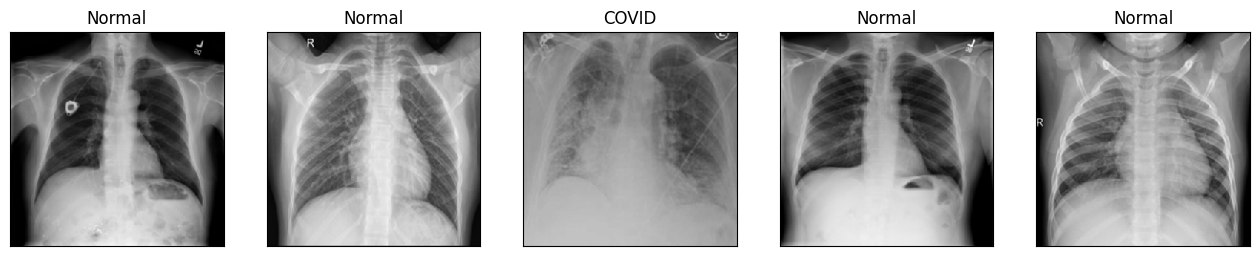

In [9]:
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

**rescale value** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !

 After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]

In [10]:
X = X.astype('float32')/255

In [11]:
# Let's confirm the number of classes-
no_of_classes = len(np.unique(y))
no_of_classes

2

Our machine learning problem is a **binary classification problem**, we will detect whether a person is infected or not.

In [12]:
y

array([1, 1, 0, ..., 1, 1, 0])

## converts a class vector (integers) to binary class matrix

### performing the one-hot encoding on the labels

In [13]:
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

### Split the data into train, test and valid subsets

Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])


The train Data Shape  11046


In [15]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The validation Data Shape  1381
The test Data Shape  1381


In [16]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


**(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN


### **CNN Implementation**

### Fine tuning RestNet50 pre-trained model

Here we are going to use [**Transfer Learning**](https://keras.io/guides/transfer_learning/) with advanced and popular VGG16 architecture with pre-trained weights on the popular **ImageNet** dataset. Then adapt it to our dataset. So, it will be our base Model

In [17]:
from keras.applications import ResNet50
from keras.layers import BatchNormalization

In [18]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(no_of_classes, activation='softmax'))

model.layers[0].trainable = False

94765736/94765736 [==============================] - 7s 0us/step


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1024)              2

### Compile the model
Here I will be using **Adam** optimiser to reach to the global minima while training out model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at **1e-3 (0,001)**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [22]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(learning_rate=lr)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### **Modelling**

using model.fit_generator as I am using ImageDataGenerator to pass data to the model.

will pass train and valid data to fit_generator. In fit_generator steps_per_epoch will set the batch size to pass training data to the model and validation_steps will do the same for valid data

For callbacks, we employed 
- **ModelCheckpoint :** Callback to save the model or model weights at certain frequencies. In this case, ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring val_loss by passing save_best_only = True to ModelCheckpoint. The model will only be saved to disk if the val_loss of the model in current epoch is lower than what it was in the last epoch. So, our model will be saved on **CDX_Best.h5** file in the path specified below.

In [24]:
# Time to train our model !
epochs = 100

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "D:\project covid\CDX_Best_RestNet50.h5", save_best_only = True, verbose=1)
start = time.time()
 
 
history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/100


C:\Users\harsh\AppData\Local\Temp\ipykernel_18916\875364588.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


1380/1380 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.7909WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 172 batches). You may need to use the repeat() function when building your dataset.



Epoch 1: val_loss improved from inf to 0.45318, saving model to D:\project covid\CDX_Best_RestNet50.h5


C:\Users\harsh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1380/1380 [==============================] - 729s 528ms/step - loss: 0.4521 - accuracy: 0.7909 - val_loss: 0.4532 - val_accuracy: 0.8139
Epoch 2/100
1380/1380 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8210WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 716s 519ms/step - loss: 0.4036 - accuracy: 0.8210
Epoch 3/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 788s 571ms/step - loss: 0.3797 - accuracy: 0.8320
Epoch 4/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8372WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 774s 561ms/step - loss: 0.3749 - accuracy: 0.8372
Epoch 5/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8521WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 783s 568ms/step - loss: 0.3451 - accuracy: 0.8521
Epoch 6/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8589WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 780s 565ms/step - loss: 0.3362 - accuracy: 0.8589
Epoch 7/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8608WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 788s 571ms/step - loss: 0.3226 - accuracy: 0.8608
Epoch 8/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8599WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 786s 569ms/step - loss: 0.3250 - accuracy: 0.8599
Epoch 9/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8694WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 763s 552ms/step - loss: 0.3097 - accuracy: 0.8694
Epoch 10/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8713WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 776s 562ms/step - loss: 0.3092 - accuracy: 0.8713
Epoch 11/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8707WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 785s 569ms/step - loss: 0.3051 - accuracy: 0.8707
Epoch 12/100
1380/1380 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8682WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 784s 568ms/step - loss: 0.3008 - accuracy: 0.8682
Epoch 13/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 787s 570ms/step - loss: 0.2920 - accuracy: 0.8772
Epoch 14/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 1039s 753ms/step - loss: 0.2951 - accuracy: 0.8740
Epoch 15/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 1001s 725ms/step - loss: 0.2804 - accuracy: 0.8839
Epoch 16/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8825WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 614s 445ms/step - loss: 0.2835 - accuracy: 0.8825
Epoch 17/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.8811WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 713s 517ms/step - loss: 0.2779 - accuracy: 0.8811
Epoch 18/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8833WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 755s 547ms/step - loss: 0.2781 - accuracy: 0.8833
Epoch 19/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8830WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 720s 522ms/step - loss: 0.2729 - accuracy: 0.8830
Epoch 20/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8824WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 682s 494ms/step - loss: 0.2799 - accuracy: 0.8824
Epoch 21/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.8808WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 679s 492ms/step - loss: 0.2769 - accuracy: 0.8808
Epoch 22/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.8862WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 676s 490ms/step - loss: 0.2631 - accuracy: 0.8862
Epoch 23/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 734s 532ms/step - loss: 0.2571 - accuracy: 0.8918
Epoch 24/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.8894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 772s 559ms/step - loss: 0.2578 - accuracy: 0.8894
Epoch 25/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8974WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 786s 570ms/step - loss: 0.2560 - accuracy: 0.8974
Epoch 26/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.8922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 672s 487ms/step - loss: 0.2612 - accuracy: 0.8922
Epoch 27/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.8886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 677s 490ms/step - loss: 0.2659 - accuracy: 0.8886
Epoch 28/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.8931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 666s 483ms/step - loss: 0.2545 - accuracy: 0.8931
Epoch 29/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.8927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 697s 505ms/step - loss: 0.2552 - accuracy: 0.8927
Epoch 30/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 700s 507ms/step - loss: 0.2513 - accuracy: 0.8944
Epoch 31/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 690s 500ms/step - loss: 0.2585 - accuracy: 0.8944
Epoch 32/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 769s 557ms/step - loss: 0.2601 - accuracy: 0.8929
Epoch 33/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 775s 562ms/step - loss: 0.2530 - accuracy: 0.8941
Epoch 34/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 714s 518ms/step - loss: 0.2415 - accuracy: 0.9007
Epoch 35/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 720s 521ms/step - loss: 0.2466 - accuracy: 0.9012
Epoch 36/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.8937WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 847s 614ms/step - loss: 0.2524 - accuracy: 0.8937
Epoch 37/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 865s 627ms/step - loss: 0.2453 - accuracy: 0.9001
Epoch 38/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.8964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 872s 632ms/step - loss: 0.2454 - accuracy: 0.8964
Epoch 39/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 763s 553ms/step - loss: 0.2412 - accuracy: 0.9022
Epoch 40/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.8987WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 790s 572ms/step - loss: 0.2455 - accuracy: 0.8987
Epoch 41/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 782s 566ms/step - loss: 0.2493 - accuracy: 0.8989
Epoch 42/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 768s 557ms/step - loss: 0.2447 - accuracy: 0.9002
Epoch 43/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.8997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 719s 521ms/step - loss: 0.2480 - accuracy: 0.8997
Epoch 44/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 780s 565ms/step - loss: 0.2414 - accuracy: 0.9013
Epoch 45/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 822s 595ms/step - loss: 0.2385 - accuracy: 0.9012
Epoch 46/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 797s 577ms/step - loss: 0.2409 - accuracy: 0.9025
Epoch 47/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 764s 554ms/step - loss: 0.2429 - accuracy: 0.9017
Epoch 48/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 839s 608ms/step - loss: 0.2353 - accuracy: 0.9034
Epoch 49/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.8972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 1049s 760ms/step - loss: 0.2444 - accuracy: 0.8972
Epoch 50/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9004WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 1000s 724ms/step - loss: 0.2418 - accuracy: 0.9004
Epoch 51/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.8997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 959s 694ms/step - loss: 0.2418 - accuracy: 0.8997
Epoch 52/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 968s 701ms/step - loss: 0.2373 - accuracy: 0.9008
Epoch 53/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.8978WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 925s 670ms/step - loss: 0.2435 - accuracy: 0.8978
Epoch 54/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 784s 568ms/step - loss: 0.2353 - accuracy: 0.9024
Epoch 55/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 780s 565ms/step - loss: 0.2335 - accuracy: 0.9056
Epoch 56/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 764s 553ms/step - loss: 0.2222 - accuracy: 0.9071
Epoch 57/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9028WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 750s 543ms/step - loss: 0.2378 - accuracy: 0.9028
Epoch 58/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9114WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 766s 555ms/step - loss: 0.2271 - accuracy: 0.9114
Epoch 59/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 765s 554ms/step - loss: 0.2273 - accuracy: 0.9042
Epoch 60/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 774s 561ms/step - loss: 0.2219 - accuracy: 0.9074
Epoch 61/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 755s 547ms/step - loss: 0.2374 - accuracy: 0.9017
Epoch 62/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9070WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 768s 556ms/step - loss: 0.2255 - accuracy: 0.9070
Epoch 63/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 770s 558ms/step - loss: 0.2285 - accuracy: 0.9061
Epoch 64/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9063WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 747s 541ms/step - loss: 0.2312 - accuracy: 0.9063
Epoch 65/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 720s 522ms/step - loss: 0.2260 - accuracy: 0.9095
Epoch 66/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9039WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 713s 517ms/step - loss: 0.2374 - accuracy: 0.9039
Epoch 67/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9086WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 810s 587ms/step - loss: 0.2246 - accuracy: 0.9086
Epoch 68/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 826s 598ms/step - loss: 0.2281 - accuracy: 0.9053
Epoch 69/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 836s 605ms/step - loss: 0.2236 - accuracy: 0.9108
Epoch 70/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 841s 610ms/step - loss: 0.2223 - accuracy: 0.9116
Epoch 71/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 847s 613ms/step - loss: 0.2122 - accuracy: 0.9126
Epoch 72/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 829s 600ms/step - loss: 0.2235 - accuracy: 0.9069
Epoch 73/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 837s 606ms/step - loss: 0.2235 - accuracy: 0.9153
Epoch 74/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 849s 615ms/step - loss: 0.2210 - accuracy: 0.9104
Epoch 75/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 847s 613ms/step - loss: 0.2280 - accuracy: 0.9072
Epoch 76/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9115WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 846s 613ms/step - loss: 0.2189 - accuracy: 0.9115
Epoch 77/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 762s 552ms/step - loss: 0.2141 - accuracy: 0.9118
Epoch 78/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 736s 533ms/step - loss: 0.2201 - accuracy: 0.9075
Epoch 79/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 769s 557ms/step - loss: 0.2279 - accuracy: 0.9101
Epoch 80/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 731s 529ms/step - loss: 0.2215 - accuracy: 0.9109
Epoch 81/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 782s 567ms/step - loss: 0.2145 - accuracy: 0.9129
Epoch 82/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 765s 555ms/step - loss: 0.2214 - accuracy: 0.9093
Epoch 83/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 769s 557ms/step - loss: 0.2197 - accuracy: 0.9109
Epoch 84/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 800s 579ms/step - loss: 0.2132 - accuracy: 0.9129
Epoch 85/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 803s 582ms/step - loss: 0.2269 - accuracy: 0.9093
Epoch 86/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 828s 600ms/step - loss: 0.2199 - accuracy: 0.9113
Epoch 87/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 815s 590ms/step - loss: 0.2238 - accuracy: 0.9083
Epoch 88/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 792s 574ms/step - loss: 0.2249 - accuracy: 0.9118
Epoch 89/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 671s 486ms/step - loss: 0.2256 - accuracy: 0.9078
Epoch 90/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9065WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 782s 566ms/step - loss: 0.2330 - accuracy: 0.9065
Epoch 91/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9082WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 796s 577ms/step - loss: 0.2310 - accuracy: 0.9082
Epoch 92/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 945s 684ms/step - loss: 0.2299 - accuracy: 0.9046
Epoch 93/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 760s 551ms/step - loss: 0.2221 - accuracy: 0.9104
Epoch 94/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 733s 531ms/step - loss: 0.2294 - accuracy: 0.9064
Epoch 95/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9074WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 725s 525ms/step - loss: 0.2251 - accuracy: 0.9074
Epoch 96/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9128WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 778s 564ms/step - loss: 0.2192 - accuracy: 0.9128
Epoch 97/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 795s 576ms/step - loss: 0.2189 - accuracy: 0.9102
Epoch 98/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9106WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 791s 573ms/step - loss: 0.2206 - accuracy: 0.9106
Epoch 99/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 707s 512ms/step - loss: 0.2309 - accuracy: 0.9041
Epoch 100/100
1380/1380 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


1380/1380 [==============================] - 697s 505ms/step - loss: 0.2254 - accuracy: 0.9100

 This Model took 78384.03 seconds (1306.4 minutes) to train for 100 epochs


### **Evaluation**

In [25]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

173/173 - 82s - loss: 4.3339 - accuracy: 0.9276 - 82s/epoch - 472ms/step
Accuracy: 92.76%
Loss: 4.333920478820801


### Accuracy and Loss graphs

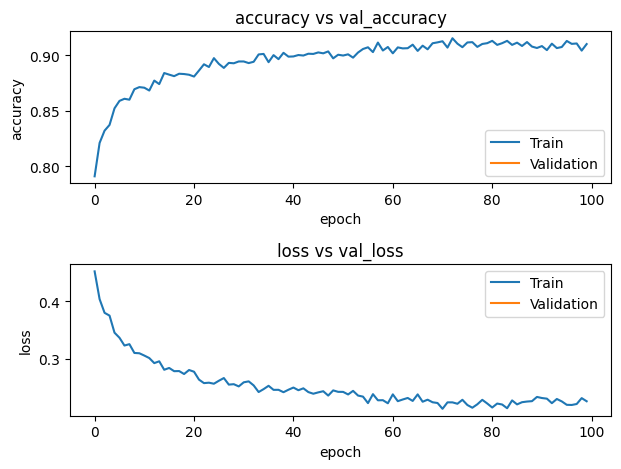

In [28]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

44/44 [==============================] - 53s 1s/step


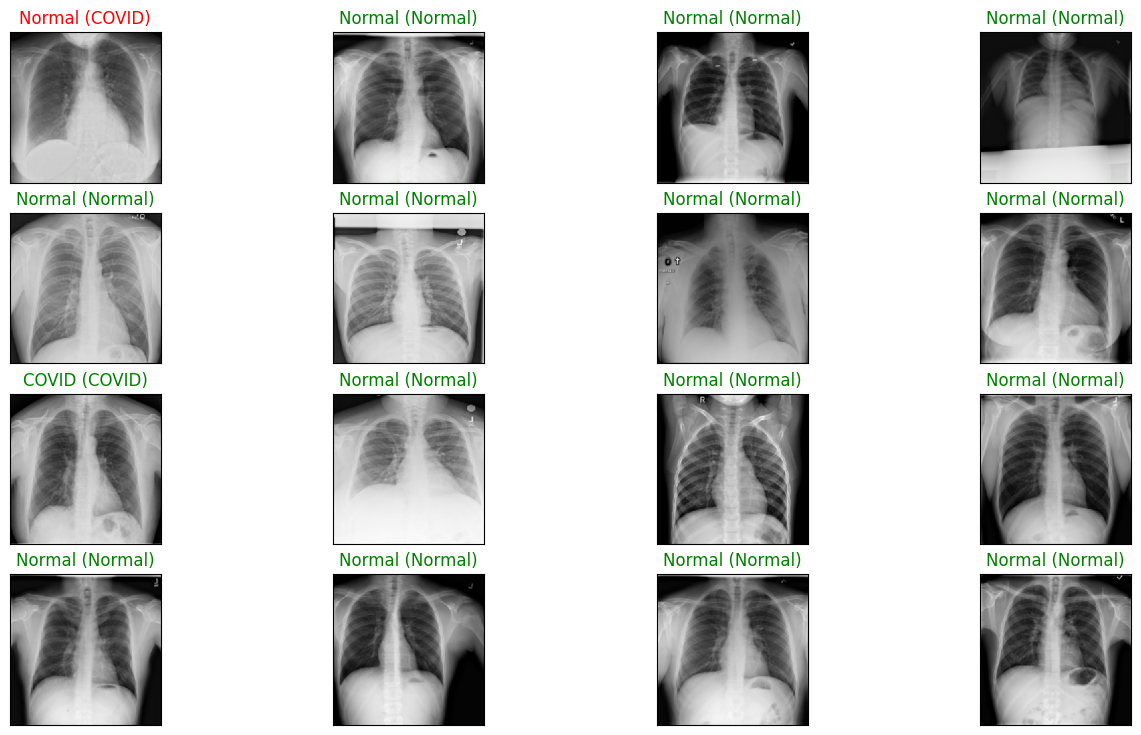

In [29]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

### Prediction

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**

44/44 [==============================] - 53s 1s/step


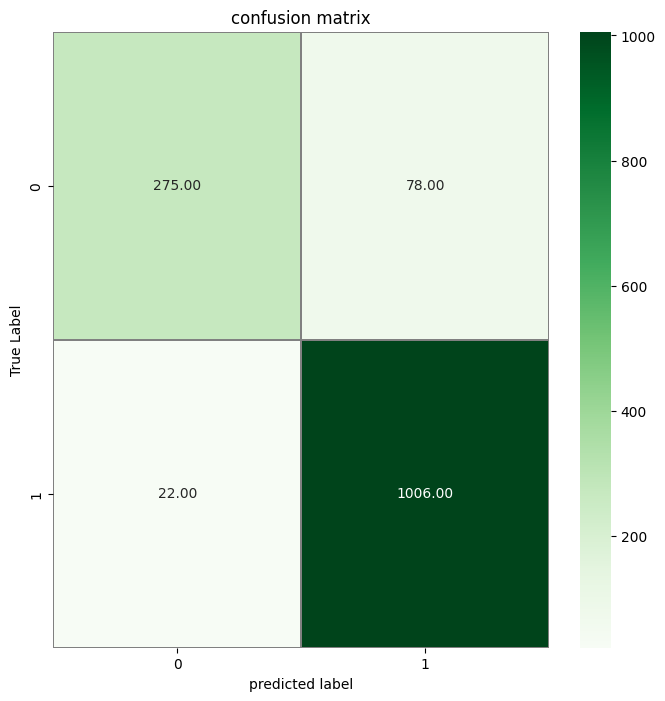

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

### report

In [31]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

       COVID       0.93      0.78      0.85       353
      Normal       0.93      0.98      0.95      1028

    accuracy                           0.93      1381
   macro avg       0.93      0.88      0.90      1381
weighted avg       0.93      0.93      0.93      1381



### Loading the model

 Here we're gonna load our best model trained befor, then make some predictions with it !

In [33]:
my_model=keras.models.load_model("D:\project covid\CDX_Best_RestNet50.h5")

44/44 [==============================] - 58s 1s/step


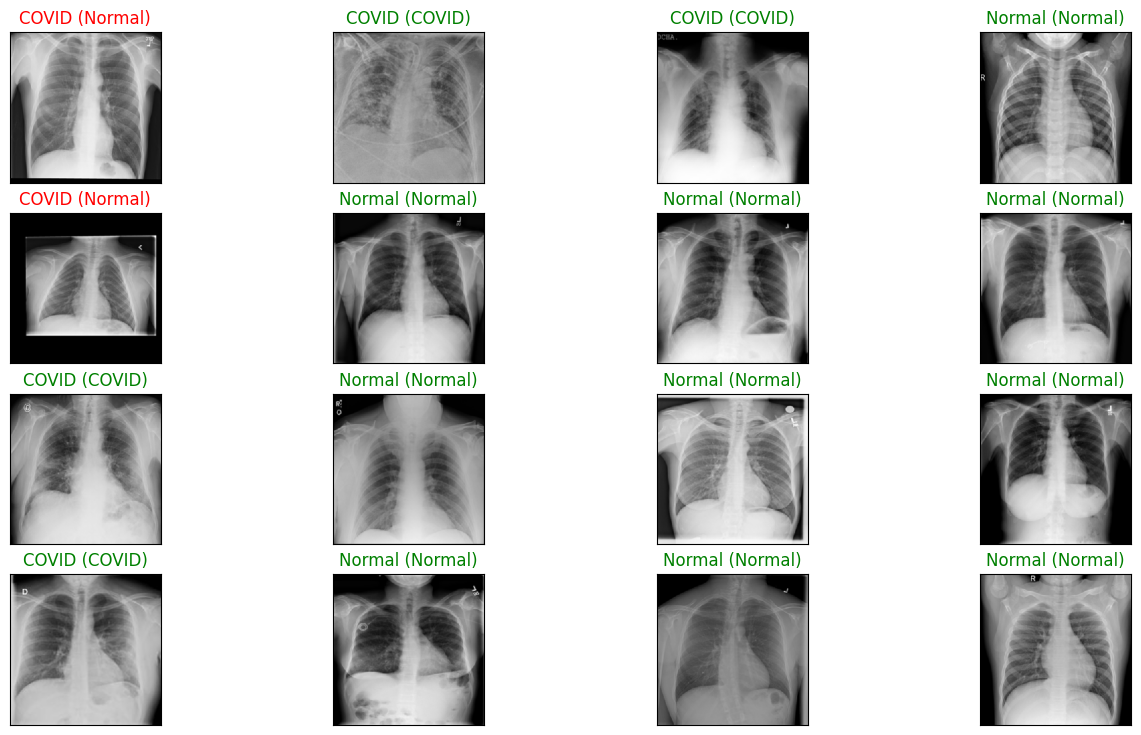

In [34]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))